In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

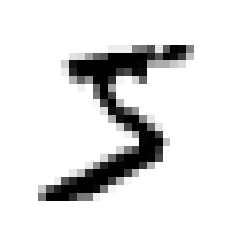

In [6]:
# print one picture
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28) # las imagenes son 28x28 

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()


In [7]:
y[0] # label de la imagen, su type es string, hay que pasarlo a number

'5'

In [8]:
import numpy as np
y = y.astype(np.uint8)

In [9]:
type(y[0])

numpy.uint8

In [10]:
# split the array
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[:60000]

In [11]:
# create a five detector (binary selector 5 or not-5)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
# use Stochastic Gradient Classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

In [14]:
# cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))
    

0.87155
0.8499
0.8632


In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(y_train_5, y_train_pred)) #TP/(TP+FP)
recall_score(y_train_5, y_train_pred) # TP/(TP+FN)

0.8370879772350012


0.6511713705958311

In [18]:
f1_score(y_train_5, y_train_pred) # 

0.7325171197343846

In [19]:
#ejemplo de como setear el threshold para subir o bajar precision vs. recall
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [20]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [21]:
threshold = 80000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

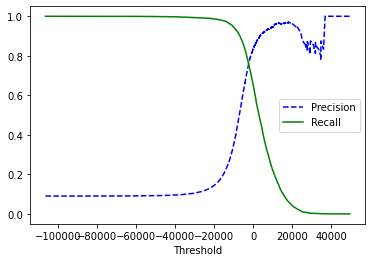

In [22]:
# como elegir el threshold?
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, threshold):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel('Threshold')
    plt.legend()
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

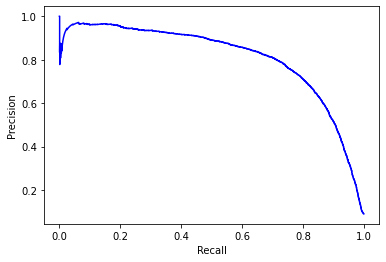

In [23]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "b")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [24]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 

In [25]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [26]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [27]:
# roc curve - plotea sensibilidad(recall) vs especificidad (precision)
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

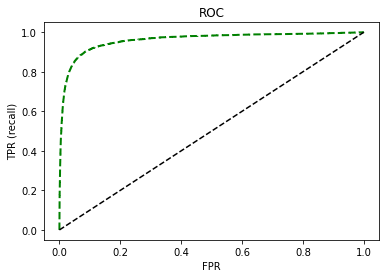

In [28]:
def plot_roc(fpr, tpr, label=None):
    plt.plot(fpr, tpr, "g--", linewidth=2)
    plt.plot([0,1], "k--")
    plt.xlabel('FPR')
    plt.ylabel('TPR (recall)')
    plt.title("ROC")
plot_roc(fpr, tpr)
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score # área bajo la curva, medida para comparar me
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [30]:
# comparar com random forest
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba") 
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

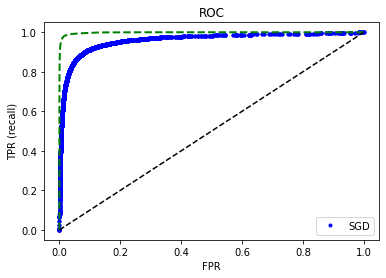

In [31]:
plt.plot(fpr, tpr, "b.", label="SGD")
plot_roc(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# clasificacion binaria, OVO strategy one vs one , OVR one vs the rest
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])


In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit]) # compara uno a uno OVR strategy
some_digit_scores

In [ ]:
np.argmax(some_digit_scores)

In [ ]:
svm_clf.classes_

In [ ]:
svm_clf.classes_[5]

In [ ]:
from sklearn.preprocessing import StandardScaler
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)